# 1. Prepare inputs

## 1. Annotate Promoter Windows with “Open/Closed” Flag

We begin with two BED files (dataset1 and dataset2), each listing 15 promoter windows around TSS:
- Columns: chromosome, start, end, id_base, expr_value, expr_rank, overlaps
- Our goal is to add an `open_flag` (1 or 0) indicating whether that 2 kb window overlaps any skeletal‐muscle ATAC‐seq peak (ENCFF150TGS.bed).
- This tissue‐specific accessibility flag will let us down‐weight or filter variants in closed promoters.

ATAC-seq measures genome-wide chromatin accessibility, and peaks are areas where the chromatin is accessible

In [96]:
import os
import pandas as pd
from pybedtools import BedTool
import numpy as np
from pyfaidx import Fasta
import csv
import pysam
import glob
import matplotlib.pyplot as plt
import random

In [84]:
BED1 = "../data/intermediate/dataset1/chr20_test15_tss±2kb.bed"
BED2 = "../data/intermediate/dataset2/chr20_test15_tss±2kb.bed"

# skeletal-muscle ATAC‐seq peaks BED
ATAC_BED = "../data/initial/ENCFF150TGS.bed"

# Output paths (append "_with_open.bed")
OUT1 = BED1.replace(".bed", "_with_open.bed")
OUT2 = BED2.replace(".bed", "_with_open.bed")

In [61]:
def load_promoter_bed(path):
    """
    Read our 8-column promoter BED.

    - `start`, `end`, `tss_pos`      → int
    - `expr_value`, `expr_rank`      → float
    - `chromosome`, `id_base`, `overlaps` → str
    """
    cols = [
        "chromosome", "start", "end", "id_base",
        "expr_value", "expr_rank", "overlaps", "tss_pos"
    ]

    df = pd.read_csv(
        path,
        sep="\t",
        names=cols,          # tell pandas the 8 expected columns
        skiprows=1,          # skip the '#chromosome …' header line
        dtype={
            "chromosome": str,
            "id_base":    str,
            "overlaps":   str
        },
        engine="python"
    )

    # numeric casts
    df["start"]      = df["start"].astype(int)
    df["end"]        = df["end"].astype(int)
    df["tss_pos"]    = df["tss_pos"].astype(int)
    df["expr_value"] = df["expr_value"].astype(float)
    df["expr_rank"]  = df["expr_rank"].astype(float)

    return df

df1 = load_promoter_bed(BED1)
print("Dataset1 promoter windows (first 5 rows):")
print(df1.head())

Dataset1 promoter windows (first 5 rows):
  chromosome     start       end          id_base  expr_value  expr_rank  \
0      chr20  24947269  24951269  ENSG00000077984       1.056      0.789   
1      chr20  37344140  37348140  ENSG00000197122       1.205      0.795   
2      chr20   9067087   9071087  ENSG00000101333       1.231      0.796   
3      chr20  52189779  52193779  ENSG00000020256       1.365      0.802   
4      chr20  25622014  25626014  ENSG00000170191       1.497      0.806   

  overlaps   tss_pos  
0        .  24949269  
1        .  37346140  
2        .   9069087  
3        .  52191779  
4        .  25624014  


## 2. Annotate “open” promoters via intersection

In [62]:
def annotate_open(promoter_df, atac_bed_obj):
    """
    Given a promoter DataFrame (with columns chromosome,start,end,id_base, …),
    create a BedTool from its first four columns, intersect with ATAC peaks,
    then build an 'open_flag' column = 1 if that promoter overlaps any peak, else 0.
    """
    # creating a bedtool from just the first four columns: (chrom, start, end, id_base)
    bed_in = promoter_df[["chromosome","start","end","id_base"]]
    promoter_bed = BedTool.from_dataframe(bed_in)

    # Intersect with ATAC_BED; -u ensures we get each promoter only once if it overlaps
    promoter_open = promoter_bed.intersect(atac_bed_obj, u=True)

    # Build a set of id_base for promoters that overlapped at least one ATAC peak
    open_ids = {f.fields[3] for f in promoter_open}

    # Assign open_flag = 1 if id_base in open_ids, else 0
    promoter_df["open_flag"] = promoter_df["id_base"].apply(lambda g: 1 if g in open_ids else 0)
    return promoter_df

In [63]:
def main():
    atac = BedTool(ATAC_BED)

    print("Annotating dataset1 …")
    df1 = load_promoter_bed(BED1)
    df1_annot = annotate_open(df1, atac)
    # Write out eight columns: (chrom, start, end, id_base, expr_val, expr_rank, overlaps, open_flag)
    df1_annot.to_csv(
        OUT1,
        sep="\t",
        index=False,
        header=False,
        columns=[
            "chromosome","start","end","id_base",
            "expr_value","expr_rank","overlaps","open_flag"
        ]
    )
    print("Wrote:", OUT1)

    print("Annotating dataset2 …")
    df2 = load_promoter_bed(BED2)
    df2_annot = annotate_open(df2, atac)
    df2_annot.to_csv(
        OUT2,
        sep="\t",
        index=False,
        header=False,
        columns=[
            "chromosome","start","end","id_base",
            "expr_value","expr_rank","overlaps","open_flag"
        ]
    )
    print("Wrote:", OUT2)


if __name__ == "__main__":
    main()

Annotating dataset1 …
Wrote: ../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open.bed
Annotating dataset2 …
Wrote: ../data/intermediate/dataset2/chr20_test15_tss±2kb_with_open.bed


## 2. Grow to 524 kb & One‐Hot Encode

Now that we have our `_with_open.bed` files (with `open_flag`), we next:

1. Read each 2 kb window.
2. Compute its true TSS = `start + 2000`.
3. Expand to ±262 144 bp (total 524 288 bp).
4. Fetch that sequence from hg38 FASTA, padding with “N” if we hit chr ends.
5. One‐hot encode A/C/G/T → 4 × 524 288 float32 array.
6. Save each array as `GENE.npy`, and collect its metadata (path, expr_value, expr_rank, overlaps, open_flag).
7. Dump a `flashzoi_meta.tsv` for each dataset to drive downstream predictions.

In [85]:
IN_BED1 = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open.bed"
IN_BED2 = "../data/intermediate/dataset2/chr20_test15_tss±2kb_with_open.bed"

OUT1_BED = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open.bed"
OUT2_BED = "../data/intermediate/dataset2/chr20_test15_tss±2kb_with_open.bed"
REF_FASTA = "../data/initial/GRCh38.primary_assembly.genome.fa"

In [66]:
# Flashzoi and Borzoi wants 524 kb windows. That is ±262 kb around the TSS.
FULL_WINDOW = 524_288  # exactly 2^19 = 524,288 bp
HALF_WIN    = FULL_WINDOW // 2  # 262,144

def one_hot_encode(seq):
    """
    Turn an uppercase DNA string into a (4, L) float32 array:
      A → [1,0,0,0]
      C → [0,1,0,0]
      G → [0,0,1,0]
      T → [0,0,0,1]
      anything else (N) → [0,0,0,0]
    """
    # create an array shape (4, len(seq))
    L = len(seq)
    arr = np.zeros((4, L), dtype=np.float32)
    mapping = {'A':0, 'C':1, 'G':2, 'T':3}     # mapping bases to row indices
    for i, base in enumerate(seq):
        if base in mapping:
            arr[mapping[base], i] = 1.0
    return arr

In [67]:
def extract_524kb_onehot(chrom, tss, fasta_obj):
    """
    given chr 20 and TSS coordinate,
    return a (4, 524288) numpy one-hot array.
    If we run off the chromosome edge, we pad with zeros at that side. # TODO: is that okay now
    """
    # coordinates in pyfaidx are 1-based inclusive, so we convert.
    # pyfaidx.Fasta[...] expects something like fasta["chr20"][start-1:end].
    tss0 = tss - 1  # convert to python 0-based, because our TSS is 1-based

    left  = tss0 - HALF_WIN
    right = tss0 + HALF_WIN - 1  # inclusive index so that total length = 524,288

    # If left < 0 or right ≥ chrom length, we’ll pad.
    seq_chars = []
    if left < 0:
        # pad on left with Ns
        seq_chars.append("N" * (-left))
        left = 0
    # now retrieve from FASTA
    chrom_seq = fasta_obj[chrom]  # FASTA record object
    chrom_len = len(chrom_seq)
    if right >= chrom_len:
        # fetch from left..end, then pad on right
        seq_chars.append(str(chrom_seq[left:]))  # pyfaidx returns Seq object, cast to str
        pad_len = right - (chrom_len - 1)
        seq_chars.append("N" * pad_len)
    else:
        # normal case: just slice left..right
        seq_chars.append(str(chrom_seq[left : right + 1]))

    final_seq = "".join(seq_chars).upper()
    if len(final_seq) != FULL_WINDOW:
        raise ValueError(
            f"One-hot sequence length mismatch: got {len(final_seq)}, expected {FULL_WINDOW}"
        )

    return one_hot_encode(final_seq)

In [68]:
#!/usr/bin/env python3
"""
Convert every promoter in a *_with_open.bed into a 524 kb one-hot array
ready for Borzoi / flashZoi, and write a flashzoi_meta.tsv alongside.
"""

# ──────────────────────────────────────────────────────────────────────────────
def extract_524kb_onehot(chrom: str, tss: int, fasta: Fasta) -> np.ndarray:
    """Return a (4 × 524 288) one-hot centred on `tss` (0-based, 1 = A)."""
    half   = 262_144
    left   = max(0, tss - half)
    right  = tss + half                       # fasta slicing is 0-based, end-exclusive
    seq    = fasta[chrom][left:right].seq.upper()

    # Pad with Ns if we hit a chromosome edge
    if len(seq) < 2 * half:
        seq = seq.ljust(2 * half, "N")

    mapping = {"A":0, "C":1, "G":2, "T":3}
    onehot  = np.zeros((4, 2 * half), dtype=np.float32)
    for i, base in enumerate(seq):
        if base in mapping:
            onehot[mapping[base], i] = 1.0
    return onehot

def prepare_for_flashzoi(in_bed: str, out_dir_prefix: str):
    """
    Expect *_with_open.bed with **8** columns:
    chrom  start  end  id_base  expr_value  expr_rank  overlaps  tss_pos
    """
    cols = ["chromosome","start","end","id_base",
            "expr_value","expr_rank","overlaps","tss_pos"]
    df    = pd.read_csv(in_bed, sep="\t", comment="#", names=cols,
                        dtype={"chromosome":str,"id_base":str,"overlaps":str})
    fasta = Fasta(REF_FASTA)

    meta_records = []
    for idx, r in df.iterrows():
        gene  = r.id_base
        chrom = r.chromosome
        tss   = int(r.tss_pos)

        onehot = extract_524kb_onehot(chrom, tss, fasta)

        out_npy = os.path.join(out_dir_prefix, f"{gene}.npy")
        np.save(out_npy, onehot)

        meta_records.append({
            "gene":        gene,
            "onehot_path": out_npy,
            "expr_value":  float(r.expr_value),
            "expr_rank":   float(r.expr_rank),
            "overlaps2kb": r.overlaps
        })
        print(f"[{idx+1}/{len(df)}]  Saved {gene}.npy")

    pd.DataFrame(meta_records).to_csv(
        os.path.join(out_dir_prefix, "flashzoi_meta.tsv"),
        sep="\t", index=False
    )
    print("✓ Done prepping", len(meta_records), "promoters")

if __name__ == "__main__":
    IN_BED1 = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open.bed"
    IN_BED2 = "../data/intermediate/dataset2/chr20_test15_tss±2kb_with_open.bed"

    ds1_dir = os.path.join(os.path.dirname(IN_BED1), "flashzoi_inputs")
    ds2_dir = os.path.join(os.path.dirname(IN_BED2), "flashzoi_inputs")
    os.makedirs(ds1_dir, exist_ok=True)
    os.makedirs(ds2_dir, exist_ok=True)

    print("Preparing dataset 1 …")
    prepare_for_flashzoi(IN_BED1, ds1_dir)

    print("Preparing dataset 2 …")
    prepare_for_flashzoi(IN_BED2, ds2_dir)

Preparing dataset 1 …
[1/15]  Saved ENSG00000077984.npy
[2/15]  Saved ENSG00000197122.npy
[3/15]  Saved ENSG00000101333.npy
[4/15]  Saved ENSG00000020256.npy
[5/15]  Saved ENSG00000170191.npy
[6/15]  Saved ENSG00000149639.npy
[7/15]  Saved ENSG00000088827.npy
[8/15]  Saved ENSG00000124217.npy
[9/15]  Saved ENSG00000089123.npy
[10/15]  Saved ENSG00000171940.npy
[11/15]  Saved ENSG00000089057.npy
[12/15]  Saved ENSG00000101052.npy
[13/15]  Saved ENSG00000131061.npy
[14/15]  Saved ENSG00000158445.npy
[15/15]  Saved ENSG00000196839.npy
✓ Done prepping 15 promoters
Preparing dataset 2 …
[1/15]  Saved ENSG00000171984.npy
[2/15]  Saved ENSG00000101000.npy
[3/15]  Saved ENSG00000078699.npy
[4/15]  Saved ENSG00000125821.npy
[5/15]  Saved ENSG00000130699.npy
[6/15]  Saved ENSG00000080189.npy
[7/15]  Saved ENSG00000126005.npy
[8/15]  Saved ENSG00000130703.npy
[9/15]  Saved ENSG00000243509.npy
[10/15]  Saved ENSG00000088298.npy
[11/15]  Saved ENSG00000042062.npy
[12/15]  Saved ENSG00000125971.npy


## 3. Annotate variants

In [97]:
META_TSV      = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open/flashzoi_inputs/flashzoi_meta.tsv"
MANE_SUMMARY  = "../data/initial/MANE.GRCh38.v1.4.summary.txt"
GNOMAD_VCF    = "../data/initial/gnomad.genomes.v4.1.sites.chr20.vcf.bgz"
OUT_BASE      = "../data/intermediate/dataset1/flashzoi_inputs/variants"
# Fixed half‐window for a 524 kb total (262 144 = 524 288/2)
HALF_WIN = 262_144
CHROM    = "chr20"
EDGE_BUFFER   = 100_000    # skip genes whose TSS is within 100 kb of a chromosome end
MIN_AF        = 0.001      # drop variants with AF < 0.001
MIN_AF       = 1e-4                  # gnomAD allele-freq threshold
MAX_SNPS     = 20_000                # cap rows per gene (after AF filter)
RNG          = random.Random(2025)   # reproducible subsampling

- META_TSV: this is the per-gene meta file generated when we one-hot-encoded ±2 kb windows (contains gene, onehot_path, expr_value, expr_rank, overlaps2kb, and open_flag column).
- MANE_SUMMARY: to re-derive each gene’s canonical TSS (for computing ±262 kb genomic window)
- GNOMAD_VCF: bgzipped, indexed VCF of chr20 population variants, to get allele frequencies
- OUT_BASE: we’ll drop one subdirectory per gene here, each containing its ENSG…_variants.tsv.


## 1. build a map gene_id → TSS for chr20 only

In [98]:
def load_mane_tss(mane_path):
    """
    Reads the MANE summary file, drops duplicate Ensembl_Gene entries,
    strips off ".N" from Ensembl IDs, normalizes NC_000020.## → chr20,
    and returns a dict { gene_base → TSS } for only chr20.
    """
    df = pd.read_csv(mane_path, sep="\t", dtype=str).drop_duplicates(subset="Ensembl_Gene")
    # Strip off version suffix
    df["gene_base"] = df["Ensembl_Gene"].str.replace(r"\.\d+$", "", regex=True)

    # Convert "NC_000020.11" → "chr20"
    df["chromosome"] = df["GRCh38_chr"].str.replace(
        r"^NC_0+(\d+)\.\d+$", r"chr\1", regex=True
    )

    # Compute TSS: if '+' strand → chr_start, else ( '-' strand ) → chr_end
    def get_tss(row):
        return int(row["chr_start"]) if row["chr_strand"] == "+" else int(row["chr_end"])

    df["TSS"] = df.apply(get_tss, axis=1)

    # keeping only chr20
    df20 = df[df["chromosome"] == CHROM].copy()
    return dict(zip(df20["gene_base"], df20["TSS"]))

## 2. Write the header of a per‐gene variants TSV

In [102]:
def write_variants_header(outfile):
    """
    Creates a TSV with columns:
       CHROM, POS, POS0, REF, ALT, AF
    """
    with open(outfile, "w", newline="") as fo:
        writer = csv.writer(fo, delimiter="\t")
        writer.writerow([
            "CHROM", "POS", "POS0", "REF", "ALT", "AF"
        ])

## 3. Annotate each gene’s ±262 kb window

In [103]:

def annotate_variants(meta_tsv, mane_summary, vcf_path, out_base, ref_fasta):
    """Write one *_variants.tsv per gene (±262 kb around TSS)."""
    meta_df  = pd.read_csv(meta_tsv, sep="\t")
    tss_dict = load_mane_tss(mane_summary)

    print(f"Loaded {len(meta_df)} genes")
    print(f"Found {len(tss_dict)} chr20 TSS entries")

    vcf = pysam.VariantFile(vcf_path)

    contigs = set(vcf.header.contigs)
    use_contig = "chr20" if "chr20" in contigs else "20"
    print("Using VCF contig name:", use_contig)

    with Fasta(ref_fasta) as fasta:
        chr_len = len(fasta[use_contig])

        for idx, row in meta_df.iterrows():
            gene = row["gene"]
            if gene not in tss_dict:
                continue

            tss = tss_dict[gene]
            if tss < EDGE_BUFFER or (chr_len - tss) < EDGE_BUFFER:
                continue

            left, right = max(1, tss - HALF_WIN), tss + HALF_WIN - 1
            print(f"[{idx+1}] {gene}: {left:,}-{right:,}")

            rows = []
            for rec in vcf.fetch(use_contig, left - 1, right):
                af = rec.info.get("AF")
                if af is None:           # gnomAD genotype missing
                    continue
                af_val = af[0] if isinstance(af, (list, tuple)) else af
                if af_val < MIN_AF:
                    continue

                pos0 = rec.pos - left
                af_str = f"{af_val:.6f}"
                for alt in rec.alts:
                    rows.append([rec.chrom, rec.pos, pos0, rec.ref, alt, af_str])

            # cap to MAX_SNPS -----------------------------------------------------------
            if len(rows) > MAX_SNPS:
                rows = RNG.sample(rows, MAX_SNPS)
                print(f"    capped to {MAX_SNPS:,} variants")

            # Write once (header + rows) ------------------------------------------------
            gene_dir = os.path.join(out_base, gene)
            os.makedirs(gene_dir, exist_ok=True)
            var_tsv = os.path.join(gene_dir, f"{gene}_variants.tsv")

            with open(var_tsv, "w", newline="") as fo:
                w = csv.writer(fo, delimiter="\t")
                w.writerow(["chrom","pos","pos0","ref","alt","AF"])   # header
                w.writerows(rows)

            print(f"    → wrote {len(rows):,} rows → {var_tsv}")

    vcf.close()
    print("Done annotating every gene.")

if __name__ == "__main__":
    os.makedirs(OUT_BASE, exist_ok=True)
    annotate_variants(META_TSV, MANE_SUMMARY, GNOMAD_VCF, OUT_BASE, REF_FASTA)

Loaded 15 genes
Found 524 chr20 TSS entries
Using VCF contig name: chr20
[1] ENSG00000077984: 24,687,125-25,211,412
    → wrote 17,004 rows → ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000077984/ENSG00000077984_variants.tsv
[2] ENSG00000197122: 37,083,996-37,608,283
    → wrote 16,686 rows → ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000197122/ENSG00000197122_variants.tsv
[3] ENSG00000101333: 8,806,943-9,331,230
    → wrote 13,745 rows → ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000101333/ENSG00000101333_variants.tsv
[4] ENSG00000020256: 51,929,635-52,453,922
    → wrote 17,355 rows → ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000020256/ENSG00000020256_variants.tsv
[5] ENSG00000170191: 25,361,870-25,886,157
    → wrote 16,928 rows → ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000170191/ENSG00000170191_variants.tsv
[6] ENSG00000149639: 36,601,394-37,125,681
    → wrote 17,882 rows → ../data/interme

## 4. Checking final data

In [95]:
import glob, pandas as pd
counts = {}
for tsv in glob.glob("../data/intermediate/dataset1/flashzoi_inputs/variants/*/*.tsv"):
    gene = tsv.split("/")[-2]
    df   = pd.read_csv(tsv, sep="\t")
    counts[gene] = len(df)
print(pd.Series(counts).describe())

count       15.000000
mean     16805.066667
std       1559.121661
min      13745.000000
25%      16497.500000
50%      17004.000000
75%      17462.000000
max      20000.000000
dtype: float64


### 2. Allele freq distribution

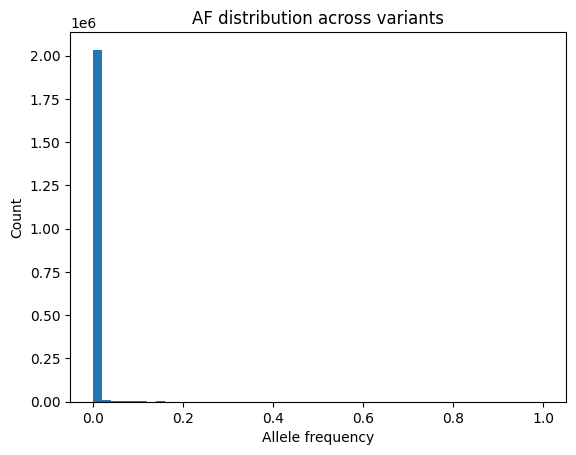

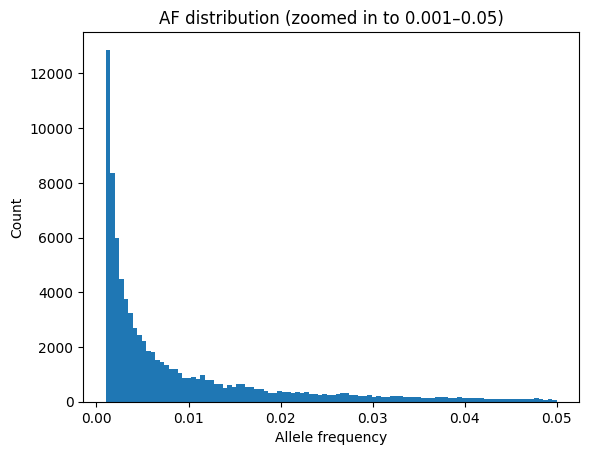

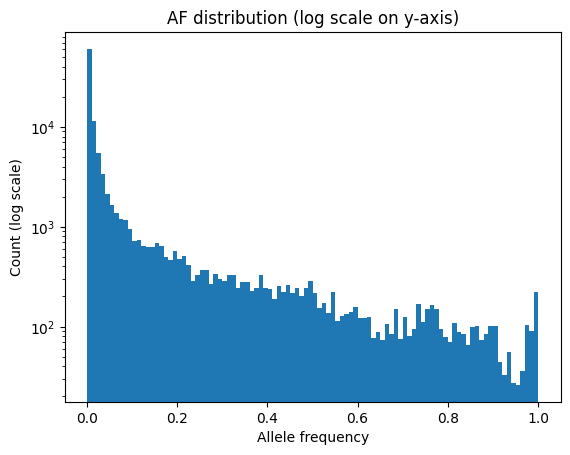

In [99]:
paths = glob.glob("../data/output/dataset1/flashzoi_inputs/variants/*/*.tsv")

all_af = pd.concat([
    pd.read_csv(tsv, sep="\t")["AF"]
        .astype(float)
        .dropna()
    for tsv in paths
], ignore_index=True)

af_min = all_af.min()
af_max = all_af.max()

plt.hist(all_af, bins=50, range=(af_min, af_max))
plt.xlabel("Allele frequency")
plt.ylabel("Count")
plt.title("AF distribution across variants")
plt.show()

plt.hist(all_af, bins=100, range=(0.001, 0.05))
plt.xlabel("Allele frequency")
plt.ylabel("Count")
plt.title("AF distribution (zoomed in to 0.001–0.05)")
plt.show()

plt.hist(all_af, bins=100, range=(0.001, 1.0))
plt.yscale('log')
plt.xlabel("Allele frequency")
plt.ylabel("Count (log scale)")
plt.title("AF distribution (log scale on y-axis)")
plt.show()

In [100]:
VAR_DIR   = "../data/intermediate/dataset1/flashzoi_inputs/variants"
example = glob.glob(os.path.join(VAR_DIR, "*", "*_variants.tsv"))[0]
print("Example file:", example)
pd.read_csv(example, sep="\t").head()

Example file: ../data/intermediate/dataset1/flashzoi_inputs/variants/ENSG00000131061/ENSG00000131061_variants.tsv


,chrom,pos,pos0,ref,alt,AF
0,chr20,33469871,19,C,T,0.000105
1,chr20,33469936,84,C,A,0.000178
2,chr20,33470089,237,C,T,0.000118
3,chr20,33470224,372,A,G,0.000138
4,chr20,33470422,570,G,A,0.000637


## 3. Sanity check for hot-encodes

In [101]:
ONEHOT_DIR = "../data/intermediate/dataset1/chr20_test15_tss±2kb_with_open/flashzoi_inputs"

rows = []
for fn in glob.glob(os.path.join(ONEHOT_DIR, "*.npy")):
    gene = os.path.basename(fn).replace(".npy","")
    arr  = np.load(fn)
    shape_ok   = (arr.shape == (4, 524288))
    sum_per_ch = arr.sum(axis=1)
    all_zero   = (sum_per_ch==0).all()
    any_zero_ch = (sum_per_ch==0).any()
    rows.append({
        "gene":       gene,
        "shape":      arr.shape,
        "shape_ok":   shape_ok,
        "sum_A":      int(sum_per_ch[0]),
        "sum_C":      int(sum_per_ch[1]),
        "sum_G":      int(sum_per_ch[2]),
        "sum_T":      int(sum_per_ch[3]),
        "any_zero_ch":any_zero_ch,
        "all_zero":   all_zero
    })

df = pd.DataFrame(rows)
print("Total arrays:", len(df))
print("Bad shapes:", df[~df["shape_ok"]].shape[0])
print("Any channel all-zero:", df["any_zero_ch"].sum())
print("Fully zero arrays:", df["all_zero"].sum())
df.sample(5)

Total arrays: 30
Bad shapes: 0
Any channel all-zero: 0
Fully zero arrays: 0


,gene,shape,shape_ok,sum_A,sum_C,sum_G,sum_T,any_zero_ch,all_zero
9,ENSG00000171940,"(4, 524288)",True,147658,116016,114190,146424,False,False
12,ENSG00000124217,"(4, 524288)",True,136769,120487,121999,145033,False,False
25,ENSG00000131061,"(4, 524288)",True,131830,122097,123939,146422,False,False
1,ENSG00000089123,"(4, 524288)",True,167751,104857,99914,151766,False,False
27,ENSG00000196839,"(4, 524288)",True,141265,122599,121894,138530,False,False
